In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk transformers torch datasets evaluate tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:
      Successfully uninstalled dill-0.4.0━━━━━━━━━━━━━━━━━━━━━━━━━  6/17 [dill]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [evaluate]/17 [datasets]ers]ub]


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import torch
import re
from datetime import datetime
from tqdm import tqdm

# Import Hugging Face libraries
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    pipeline
)
from datasets import Dataset, DatasetDict
import evaluate

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
CUDA Version: 12.8
Available GPU memory: 34.19 GB


## 2. Data Loading


In [6]:
# Define paths
PROCESSED_REVIEWS_PATH = "data/processed/processed_reviews_20250522_152822.csv" 

# Create directories for model output 
os.makedirs("./models", exist_ok=True)
os.makedirs("./models/sentiment_analysis", exist_ok=True)

In [7]:
# Load the processed review data
try:
    reviews_df = pd.read_csv(PROCESSED_REVIEWS_PATH)
    print(f"Loaded {len(reviews_df)} reviews")
    display(reviews_df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please update the PROCESSED_REVIEWS_PATH with the correct file path.")

Loaded 1270 reviews


,review_id,rating,text,date,cleaned_text,review_length
0,laptop_142_review_1,5,Absolutely love this laptop! The performance f...,2025-3-23,Absolutely love this laptop The performance fo...,442
1,laptop_142_review_2,5,Fantastic gaming laptop for the price. Getting...,2025-3-23,Fantastic gaming laptop for the price Getting ...,353
2,laptop_142_review_3,5,Exceeded my expectations! Perfect for gaming. ...,2025-2-8,Exceeded my expectations Perfect for gaming Th...,344
3,laptop_142_review_4,4,Absolutely love this laptop! The performance f...,2025-3-14,Absolutely love this laptop The performance fo...,430
4,laptop_142_review_5,4,Absolutely love this laptop! The performance f...,2025-1-16,Absolutely love this laptop The performance fo...,439


## 3. Data Preparation for Sentiment Analysis


In [8]:
# Prepare data for sentiment analysis
def prepare_sentiment_data(df):
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Filter out rows with missing text or ratings
    df = df.dropna(subset=['cleaned_text', 'rating'])
    
    # Convert ratings to sentiment labels
    # 1-2: Negative, 3: Neutral, 4-5: Positive
    def rating_to_sentiment(rating):
        if rating <= 2:
            return 0  # Negative
        elif rating == 3:
            return 1  # Neutral
        else:
            return 2  # Positive
    
    df['sentiment'] = df['rating'].apply(rating_to_sentiment)
    
    # Create a text column with cleaned text
    df['text'] = df['cleaned_text']
    
    # Select only necessary columns
    df = df[['text', 'sentiment']]
    
    return df

Sentiment Class Distribution:
0 (Negative): 192
1 (Neutral): 240
2 (Positive): 838


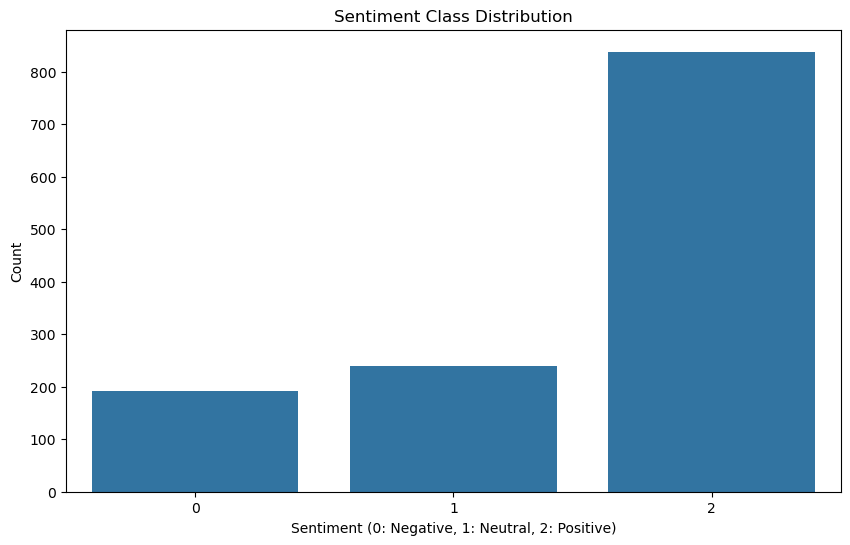

In [9]:
# Prepare sentiment data
sentiment_df = prepare_sentiment_data(reviews_df)

# Display class distribution
sentiment_counts = sentiment_df['sentiment'].value_counts().sort_index()
print("Sentiment Class Distribution:")
print(f"0 (Negative): {sentiment_counts.get(0, 0)}")
print(f"1 (Neutral): {sentiment_counts.get(1, 0)}")
print(f"2 (Positive): {sentiment_counts.get(2, 0)}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=sentiment_df)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Neutral, 2: Positive)')
plt.ylabel('Count')
plt.show()

In [10]:
# Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(sentiment_df, test_size=0.2, random_state=42, stratify=sentiment_df['sentiment'])

# Second split: 50% validation, 50% test (each 10% of the original data)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['sentiment'])

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Train set: 1016 samples
Validation set: 127 samples
Test set: 127 samples


In [11]:
# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Display dataset info
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment', '__index_level_0__'],
        num_rows: 1016
    })
    validation: Dataset({
        features: ['text', 'sentiment', '__index_level_0__'],
        num_rows: 127
    })
    test: Dataset({
        features: ['text', 'sentiment', '__index_level_0__'],
        num_rows: 127
    })
})


## 4. Model Setup and Tokenization


In [12]:
# Load DistilBERT tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# Tokenize the datasets
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"])
tokenized_datasets = tokenized_datasets.rename_column("sentiment", "label")
tokenized_datasets.set_format("torch")

print("Tokenized datasets:")
print(tokenized_datasets)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1016 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Tokenized datasets:
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1016
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 127
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 127
    })
})


In [13]:
# Load pre-trained model for sequence classification
num_labels = 3  # Negative, Neutral, Positive
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Move model to GPU if available
model = model.to(device)

# Print model architecture summary
print(model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 5. Model Training with GPU Acceleration

In [14]:
# Define metrics for evaluation
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    
    return {"accuracy": accuracy, "f1": f1}

In [39]:
# PyTorch training loop (no Trainer API required)
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch
from tqdm import tqdm

# Create dataloaders
train_dataloader = DataLoader(
    tokenized_datasets["train"], 
    batch_size=16, 
    shuffle=True
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], 
    batch_size=16
)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Training loop
num_epochs = 3
best_accuracy = 0
best_model_state = None

print("Starting training...")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            labels = batch["labels"]
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = correct / total
    
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()
        print(f"New best model with accuracy: {best_accuracy:.4f}")

# Load best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_accuracy:.4f}")

# Save the model
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f"./models/sentiment_analysis/distilbert-laptop-reviews-{timestamp}"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to: {model_save_path}")

Starting training...


Training Epoch 1: 100% 64/64 [00:02<00:00, 21.51it/s]
Validation Epoch 1: 100% 8/8 [00:00<00:00, 60.85it/s]


Epoch 1: Train Loss: 0.1848, Val Loss: 0.0058, Accuracy: 1.0000
New best model with accuracy: 1.0000


Training Epoch 2: 100% 64/64 [00:02<00:00, 25.86it/s]
Validation Epoch 2: 100% 8/8 [00:00<00:00, 64.82it/s]


Epoch 2: Train Loss: 0.0042, Val Loss: 0.0020, Accuracy: 1.0000


Training Epoch 3: 100% 64/64 [00:02<00:00, 25.80it/s]
Validation Epoch 3: 100% 8/8 [00:00<00:00, 64.88it/s]


Epoch 3: Train Loss: 0.0019, Val Loss: 0.0010, Accuracy: 1.0000
Loaded best model with validation accuracy: 1.0000
Model and tokenizer saved to: ./models/sentiment_analysis/distilbert-laptop-reviews-20250522_170006


## 6. Model Evaluation


In [41]:
# Evaluate on test set
test_dataloader = DataLoader(
    tokenized_datasets["test"], 
    batch_size=16
)

model.eval()
test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        labels = batch["labels"]
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct / total

print(f"Test Results: Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

Testing: 100% 8/8 [00:00<00:00, 32.73it/s]

Test Results: Loss: 0.0010, Accuracy: 1.0000


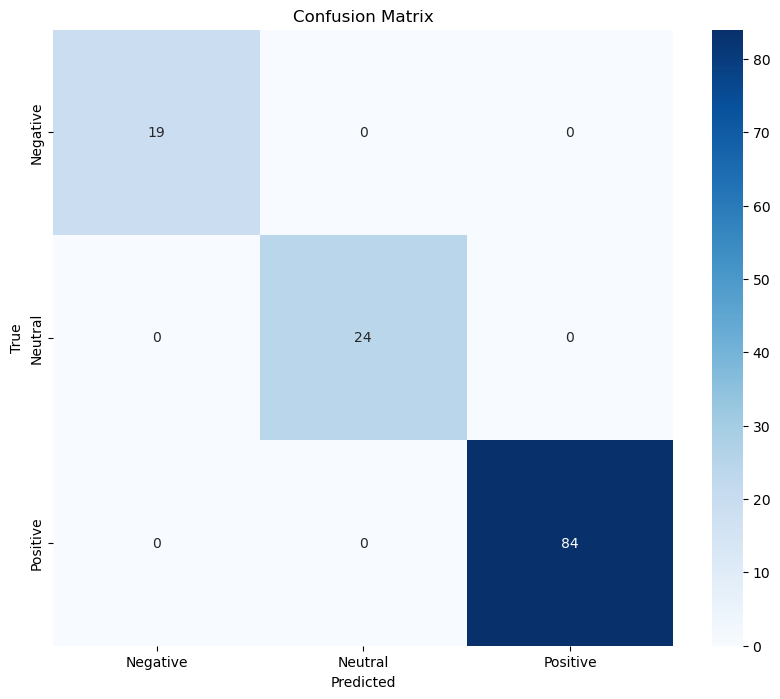

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        19
     Neutral       1.00      1.00      1.00        24
    Positive       1.00      1.00      1.00        84

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127



In [42]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))

In [44]:
# Save the model and tokenizer
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f"./models/sentiment_analysis/distilbert-laptop-reviews-{timestamp}"

# Save model directly using the HuggingFace save_pretrained method
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to: {model_save_path}")

Model and tokenizer saved to: ./models/sentiment_analysis/distilbert-laptop-reviews-20250522_170319
